<a href="https://colab.research.google.com/github/AnnikaStephens/Portfolio/blob/main/Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Bitcoin Price Prediction

The goal of this study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

<a id='0'></a>
# 1. About

Predicting a buy or sell signal for a trading strategy would be a classification problem, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

The data is obtained from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


<a id='1.2'></a>
## 2.2. Loading the Data

To reproduce the full results, the csv file (available on kaggle) should be downloaded to your computer.

In [ ]:
from google.colab import files


uploaded = files.upload()


Saving historical_data_xrp_20211118021950.csv to historical_data_xrp_20211118021950.csv


In [ ]:
# load dataset
import pandas as pd
import io

dataset = pd.read_csv(io.BytesIO(uploaded['historical_data_xrp_20211118021950.csv']))
print(dataset)


            Date  Price (Close)  ...  Real Volume  Total Fees
0     2018-11-17          0.491  ...    2.234e+08     386.140
1     2018-11-18          0.510  ...    3.726e+08     451.171
2     2018-11-19          0.469  ...    6.078e+08     547.833
3     2018-11-20          0.428  ...    7.716e+08     727.375
4     2018-11-21          0.444  ...    3.502e+08     407.500
...          ...            ...  ...          ...         ...
1092  2021-11-13          1.190  ...    5.485e+08    7152.101
1093  2021-11-14          1.188  ...    4.541e+08    3717.319
1094  2021-11-15          1.172  ...    6.357e+08   11165.285
1095  2021-11-16          1.088  ...    1.353e+09    7031.416
1096  2021-11-17          1.081  ...    6.257e+08         NaN

[1097 rows x 7 columns]


<a id='2'></a>
# 3.  Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [ ]:
# shape
dataset.shape

(1097, 7)

In [ ]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Date,Price (Close),Price (High),Price (Low),Price (Open),Real Volume,Total Fees
1092,2021-11-13,1.190,1.204,1.167,1.189,5.485e+08,7152.101
1093,2021-11-14,1.188,1.200,1.168,1.190,4.541e+08,3717.319
1094,2021-11-15,1.172,1.220,1.165,1.188,6.357e+08,11165.285
1095,2021-11-16,1.088,1.172,1.044,1.172,1.353e+09,7031.416
1096,2021-11-17,1.081,1.114,1.059,1.089,6.257e+08,NaN


In [ ]:
# describe data
set_option('precision', 3)
dataset.describe()

,Price (Close),Price (High),Price (Low),Price (Open),Real Volume,Total Fees
count,1097.000,1097.000,1097.000,1097.000,1.097e+03,1096.000
mean,0.456,0.478,0.432,0.455,6.908e+08,911.331
std,0.337,0.359,0.312,0.337,1.180e+09,2246.639
min,0.138,0.150,0.106,0.137,1.324e+07,40.119
25%,0.245,0.251,0.238,0.245,1.166e+08,163.126
50%,0.308,0.319,0.297,0.308,2.176e+08,288.737
75%,0.520,0.561,0.486,0.517,7.357e+08,698.134
max,1.835,1.967,1.652,1.838,1.172e+10,50673.312


<a id='3'></a>
# 4. Data Prep

<a id='3.1'></a>
## 4.1. Data Cleaning

In [ ]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


!!! There are null values, so we need to clean the data by filling the *NaNs* with the last available values. 

In [ ]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [ ]:
dataset=dataset.drop(columns=['Date'])

<a id='3.2'></a>
## 4.2. Prepping the data for classification

Attach label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [ ]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Price (Close)'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Price (Close)'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [ ]:
dataset.tail()

,Price (Close),Price (High),Price (Low),Price (Open),Real Volume,Total Fees,short_mavg,long_mavg,signal
1092,1.190,1.204,1.167,1.189,5.485e+08,7152.101,1.206,1.085,1.0
1093,1.188,1.200,1.168,1.190,4.541e+08,3717.319,1.204,1.086,1.0
1094,1.172,1.220,1.165,1.188,6.357e+08,11165.285,1.206,1.087,1.0
1095,1.088,1.172,1.044,1.172,1.353e+09,7031.416,1.199,1.087,1.0
1096,1.081,1.114,1.059,1.089,6.257e+08,7031.416,1.185,1.087,1.0


<a id='3.3'></a>
## 4.3. Feature Engineering

Now we construct a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The Bitocin data includes date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:

* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

This site provides more detail into the specifics of the above terms: https://thismatter.com/money/technical-analysis/momentum.htm

In [ ]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Price (Close)'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Price (Close)'], 10)
dataset['ROC30'] = ROC(dataset['Price (Close)'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Price (Close)'], 10)
dataset['MOM30'] = MOM(dataset['Price (Close)'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Price (Close)'], 10)
dataset['RSI30'] = RSI(dataset['Price (Close)'], 30)
dataset['RSI200'] = RSI(dataset['Price (Close)'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 10)
dataset['%D10'] = STOD(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 10)
dataset['%K30'] = STOK(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 30)
dataset['%D30'] = STOD(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 30)
dataset['%K200'] = STOK(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 200)
dataset['%D200'] = STOD(dataset['Price (Close)'], dataset['Price (Low)'], dataset['Price (High)'], 200)

In [ ]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Price (Close)'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Price (Close),Price (High),Price (Low),Price (Open),Real Volume,Total Fees,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1092,1.190,1.204,1.167,1.189,5.485e+08,7152.101,1.206,1.085,1.0,1.194,1.149,0.974,-0.986,4.249,-0.021,0.056,53.273,53.992,52.445,36.144,40.311,60.155,62.191,54.091,54.739,1.206,1.136,1.007
1093,1.188,1.200,1.168,1.190,4.541e+08,3717.319,1.204,1.086,1.0,1.193,1.151,0.976,2.469,4.750,-0.013,0.047,53.017,53.915,52.435,35.576,35.843,59.801,59.967,53.978,54.031,1.204,1.137,1.006
1094,1.172,1.220,1.165,1.188,6.357e+08,11165.285,1.206,1.087,1.0,1.189,1.153,0.978,1.733,7.118,0.013,0.038,49.990,53.031,52.326,29.155,33.625,55.793,58.583,52.701,53.590,1.206,1.139,1.005
1095,1.088,1.172,1.044,1.172,1.353e+09,7031.416,1.199,1.087,1.0,1.171,1.148,0.979,-10.837,0.516,-0.064,-0.006,37.550,48.714,51.760,14.626,26.452,34.864,50.153,46.035,50.905,1.199,1.139,1.003
1096,1.081,1.114,1.059,1.089,6.257e+08,7031.416,1.185,1.087,1.0,1.154,1.144,0.980,-15.719,-0.985,-0.140,-0.002,36.621,48.340,51.708,12.109,18.630,32.944,41.200,45.424,48.054,1.185,1.138,1.000


In [ ]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['Price (High)','Price (Low)','Price (Open)','short_mavg','long_mavg'], axis=1)

In [ ]:
dataset = dataset.dropna(axis=0)

In [ ]:
dataset.tail()

,Price (Close),Real Volume,Total Fees,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1092,1.190,5.485e+08,7152.101,1.0,1.194,1.149,0.974,-0.986,4.249,-0.021,0.056,53.273,53.992,52.445,36.144,40.311,60.155,62.191,54.091,54.739,1.206,1.136,1.007
1093,1.188,4.541e+08,3717.319,1.0,1.193,1.151,0.976,2.469,4.750,-0.013,0.047,53.017,53.915,52.435,35.576,35.843,59.801,59.967,53.978,54.031,1.204,1.137,1.006
1094,1.172,6.357e+08,11165.285,1.0,1.189,1.153,0.978,1.733,7.118,0.013,0.038,49.990,53.031,52.326,29.155,33.625,55.793,58.583,52.701,53.590,1.206,1.139,1.005
1095,1.088,1.353e+09,7031.416,1.0,1.171,1.148,0.979,-10.837,0.516,-0.064,-0.006,37.550,48.714,51.760,14.626,26.452,34.864,50.153,46.035,50.905,1.199,1.139,1.003
1096,1.081,6.257e+08,7031.416,1.0,1.154,1.144,0.980,-15.719,-0.985,-0.140,-0.002,36.621,48.340,51.708,12.109,18.630,32.944,41.200,45.424,48.054,1.185,1.138,1.000


<a id='3.4'></a>
## 4.4. Data Visualization

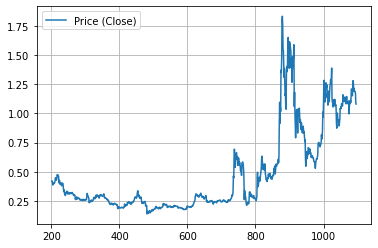

In [ ]:
dataset[['Price (Close)']].plot(grid=True)
plt.show()

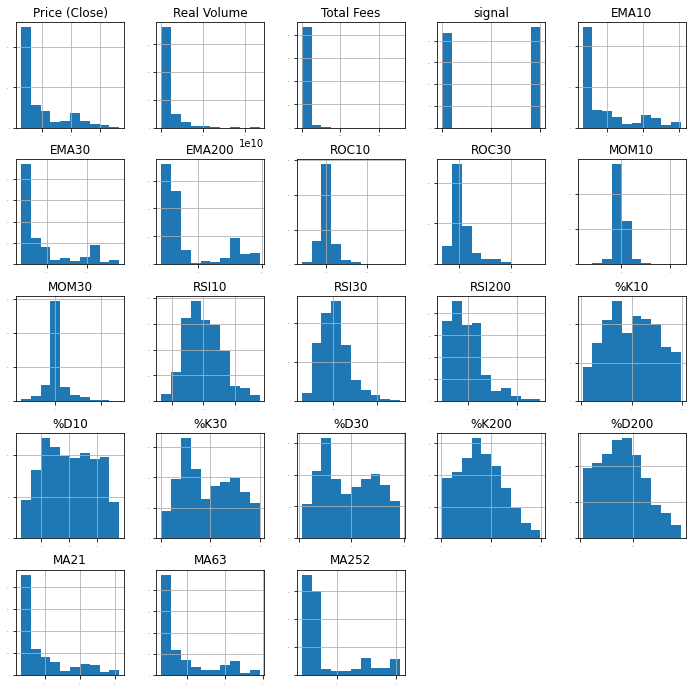

In [ ]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

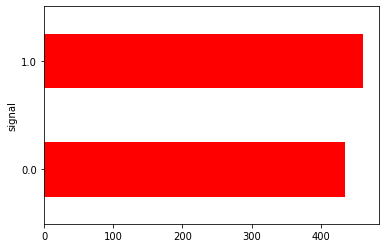

In [ ]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

We can see that the number
of the buy signals were more than the number of sell signals. 

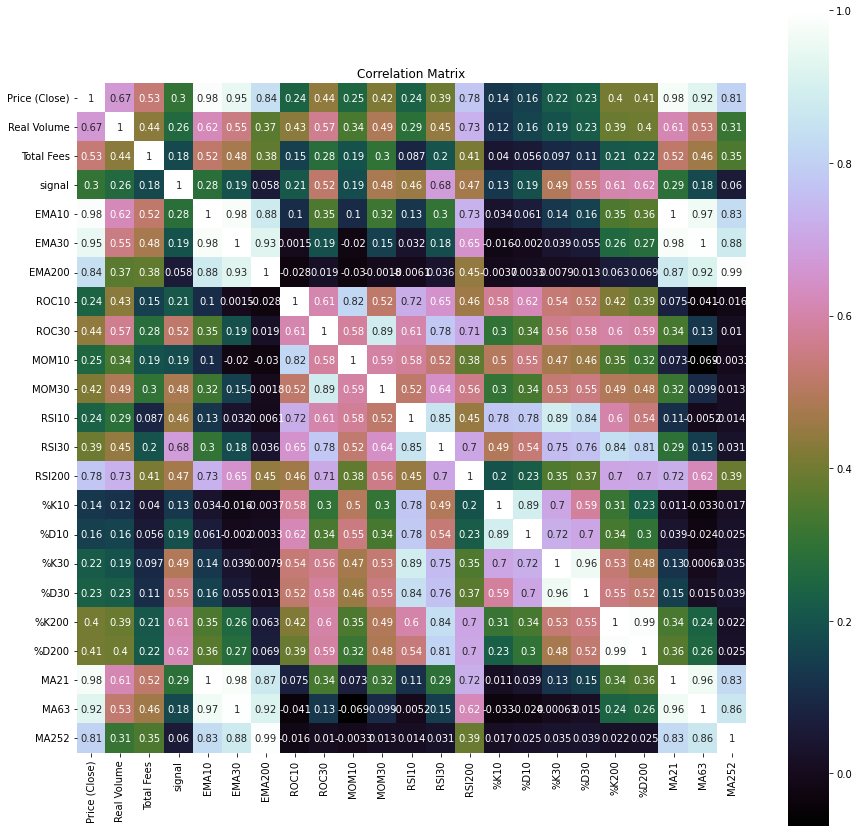

In [ ]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

Next, we evaluate the following non linear methods to know which algorithm technic is the best for the strategy

<a id='4.3.1'></a>
### 5.3.1. Models

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.515415 (0.056805)
LDA: 0.892469 (0.041061)
KNN: 0.565356 (0.067758)
CART: 0.900919 (0.025066)
NB: 0.580927 (0.058894)
NN: 0.513967 (0.057178)
AB: 0.928775 (0.023662)
GBM: 0.949726 (0.026538)
RF: 0.942723 (0.021142)


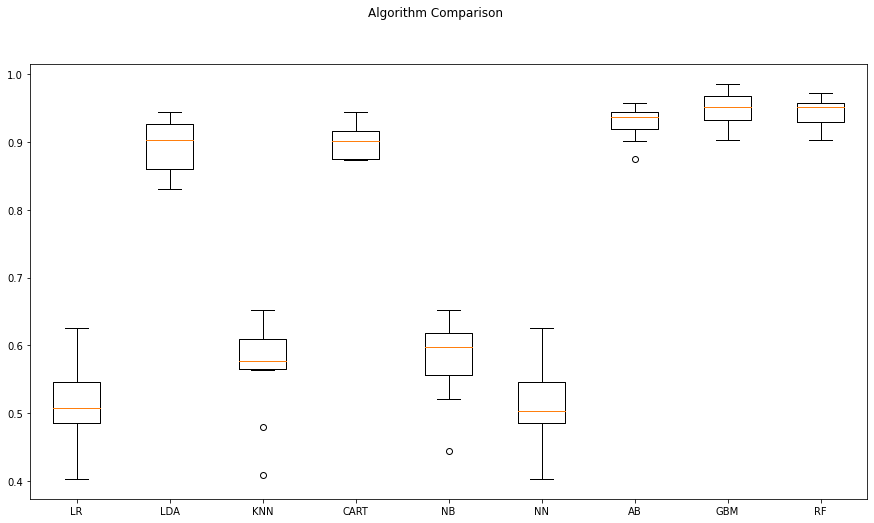

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.948337 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.903560 (0.023955) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.921772 (0.031885) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.937148 (0.024406) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.941315 (0.023271) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.910583 (0.025119) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.921811 (0.021618) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.938556 (0.025872) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.948337 (0.024078) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9611111111111111
[[87  1]
 [ 6 86]]
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96        88
         1.0       0.99      0.93      0.96        92

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



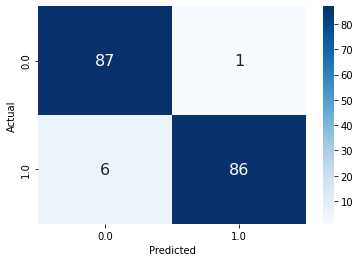

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

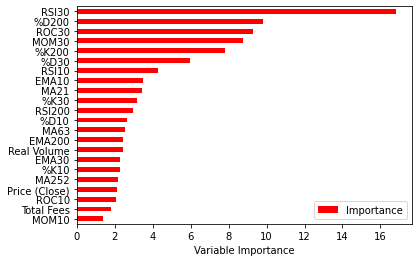

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

We see tat the Relative Strength Index (RSI) , a momentum indicator that measures the magnitude of recent price changes, has the greatst importance by far.

<a id='7'></a>
## 8. Backtesting Results

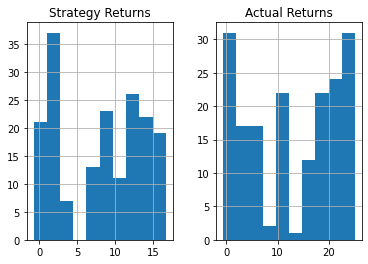

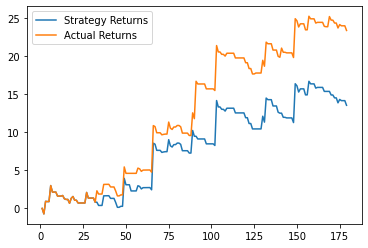

In [ ]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Price (Close)'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

__Conclusion__:

RESULTS: from the gradually increasing divergence of the strategy and actual returns, we can assume that we are missing an important variable....

1. showed that framing the problem is the first priority and we address it by engi‐
neering the features and transforming the labels according to the investment objective.

2. Feature engiineering is important - leads to intuitive features related to the trend and momentum of the price movement

3. BAcktesting - allows us to simulate a trading strategy using historical data. This is important because we can analyze risk and profitability before putting capital to real-life risk. 